In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw, ImageOps, Resamplin

import cv2
import numpy as np

### A function just to display the image

In [103]:
def display_image(img):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    plt.show()

### Function to crop a full image into a circle

In [26]:
def crop_circle(image_path):
    # Open the input image as numpy array, convert to RGB
    img = Image.open(image_path).convert("RGB")
    npImage = np.array(img)
    h, w = img.size

    # Create same size alpha layer with circle
    alpha = Image.new('L', img.size, 0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice([0, 0, h, w], 0, 360, fill=255)

    # Convert alpha Image to numpy array
    npAlpha = np.array(alpha)

    # Add alpha layer to RGB
    npImage = np.dstack((npImage, npAlpha))

    # Convert numpy array to PIL Image
    pilImage = Image.fromarray(npImage)

    # Crop the image to the circle
    pilImage = pilImage.crop((0, 0, h, w))
    pilImage = ImageOps.fit(pilImage, (2 * min(h, w),) * 2, Image.Resampling.LANCZOS)

    # Save the image
    pilImage.save('cropped_circle.png')
    return pilImage

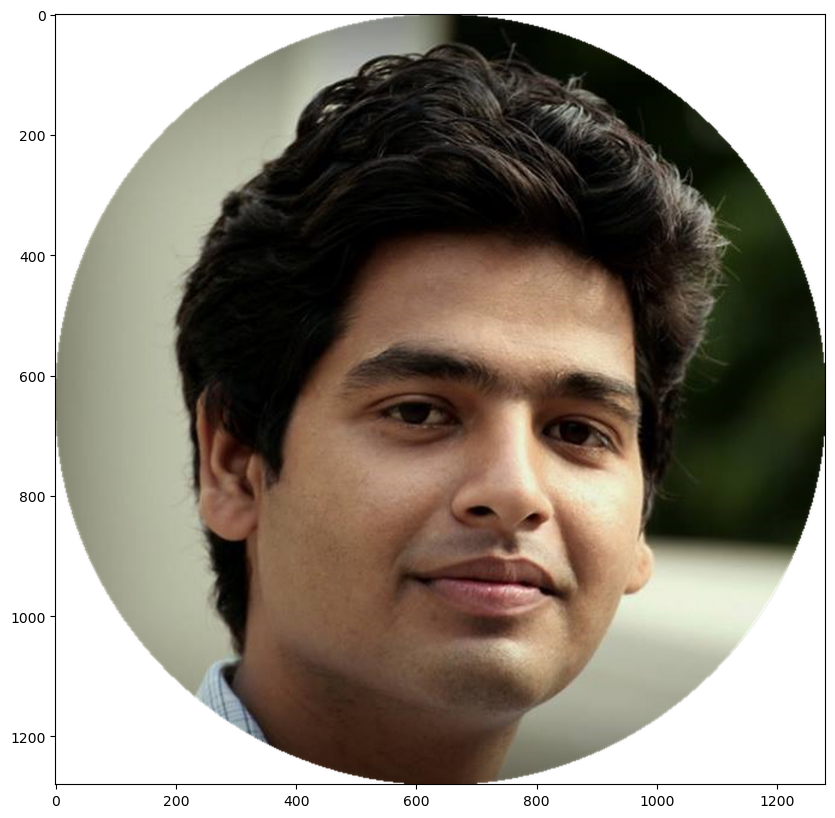

In [27]:
img_out = crop_circle('my_img.jpg')

display_image(img_out)

### Now we need a canvas for our string art drawing and we can do that using below function. It requires an input image, number of points you need(nails) and the radius for point to display

In [116]:
import math
from PIL import Image, ImageDraw

def create_canvas_with_points(circle_img, nails=300, point_radius=1):
    #List to save all the points
    points = []

    # Get the size of the circle image
    width, height = circle_img.shape[:2]

    # Create a new image with the same size as the circle image
    canvas_img = Image.new('L', (width, height), color='white')

    # Calculate the radius of the circle
    radius = width // 2

    # Calculate the angle between each point
    angle = 2 * math.pi / nails

    # Calculate the distance between each point
    distance = radius - 10

    # Draw the points on the canvas
    draw = ImageDraw.Draw(canvas_img)
    for i in range(nails):
        x = int(radius + distance * math.cos(i * angle))
        y = int(radius + distance * math.sin(i * angle))
        draw.ellipse((x-point_radius, y-point_radius, x+point_radius, y+point_radius), fill='black')
        points.append((x, y))

    # Save the canvas image
    canvas_img.save('canvas.png')

    return canvas_img, points

### Function that converts the transparent background of the cropped image into a grayscale image with white background. This will be useful later on when we perform loss calculation

In [99]:
def crop_to_white_background_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    b, g, r, a = cv2.split(img)
    
    a = cv2.bitwise_not(a)
    mask = cv2.cvtColor(a, cv2.COLOR_GRAY2BGR)
    
    bgr = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    result = cv2.add(bgr, mask)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    
    return result

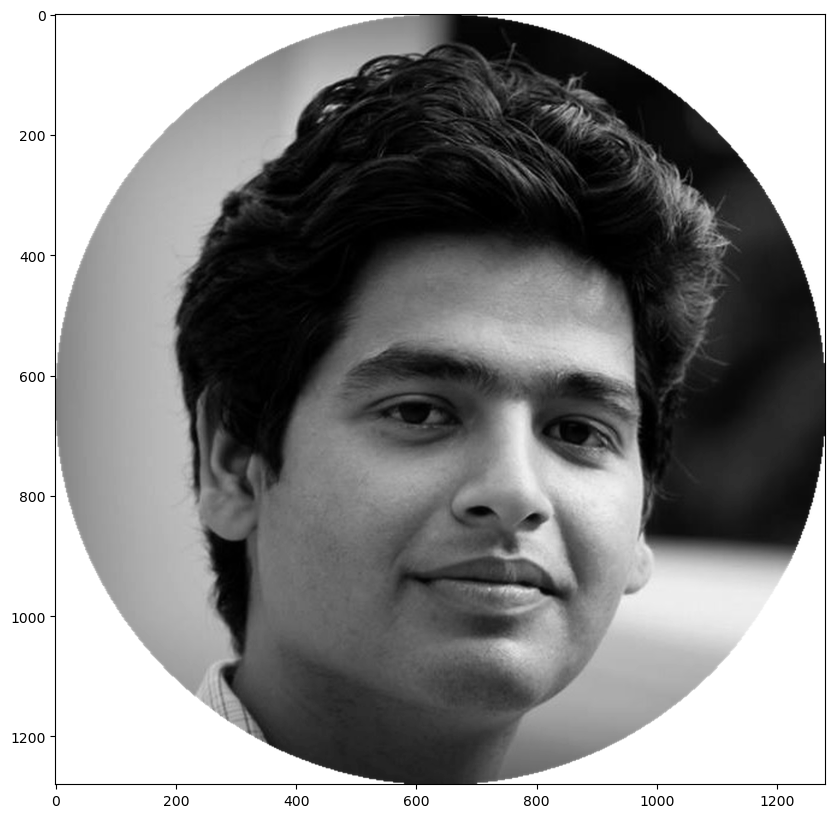

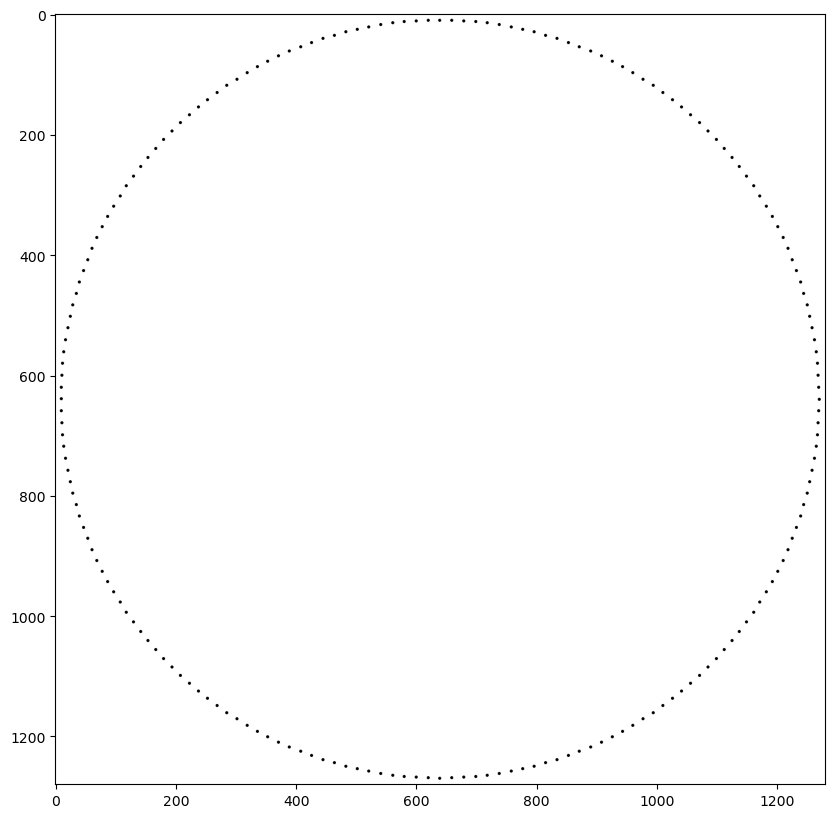

In [122]:
# cropped_img = cv2.imread('cropped_circle.png', cv2.IMREAD_UNCHANGED)

cropped_img = crop_to_white_background_image('cropped_circle.png')

canvas_out, points = create_canvas_with_points(cropped_img, nails=200, point_radius=2)
canvas_out = np.array(canvas_out)

# cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

display_image(cropped_img)
display_image(canvas_out)

### Let's see if drawing a line will work on our canvas or not

In [127]:
def draw_line(image, point1, point2, lw=1):
    # Create a copy of the image to draw on
    draw_img = image.copy()

    # Draw the line on the image
    cv2.line(draw_img, point1, point2, (0, 0, 0), thickness=lw)

    # Return the image with the line drawn on it
    return draw_img

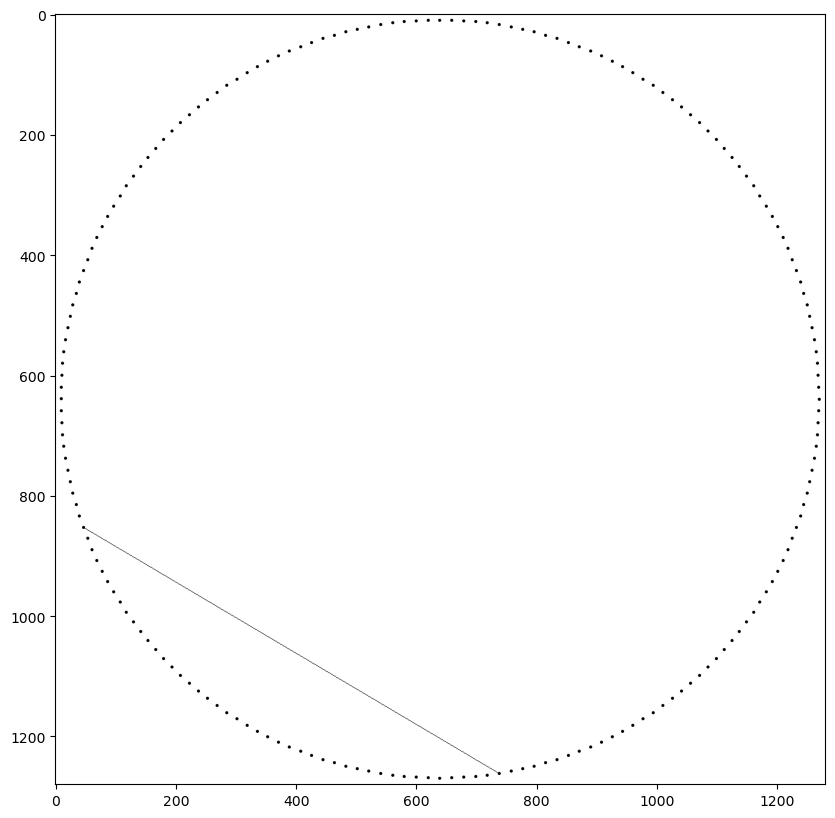

In [128]:
line_img = draw_line(canvas_out, point1=points[45], point2=points[89], lw=1)

display_image(line_img)

### Seems to be working fine. So now we need to create the algorithm that creates line one by one, figures out which next line is the best one and then move to the next best line.